In [43]:
import warnings
warnings.filterwarnings('ignore')

### Run in collab
<a href="https://colab.research.google.com/github/racousin/rl_introduction/blob/master/notebooks/3_Temporal-Difference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
# uncomment 2 lines
#!git clone https://github.com/racousin/rl_introduction.git
#from rl_introduction.rl_introduction.tools import Agent, plot_values_lake, policy_evaluation, value_iteration, discount_cumsum, run_experiment_episode_train

### Run locally

In [45]:
from rl_introduction.tools import Agent, plot_values_lake, policy_evaluation, value_iteration, discount_cumsum, MyRandomAgent, run_experiment_episode_train

### Objective
Here we present methods to solve the problem of environment and agents when the model is not known and not used (model-free).

In [46]:
import numpy as np
import gym
import matplotlib.pyplot as plt
env = gym.make('FrozenLake-v0')

In [47]:
def run_experiment_episode_train(env, agent, nb_episode):
    rewards = np.zeros(nb_episode)
    for i in range(nb_episode):
        state = env.reset()
        done = False
        rews = []
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            agent.train(current_state, action, reward, state, done)
            rews.append(reward)
        rewards[i] = sum(rews)
        print('episode: {} - cum reward {}'.format(i, rewards[i]))
    return rewards

# Usefull tools
Many times, it will be necessary for us to calculate the discount return $G_t = \sum_{k=0}^T\gamma^k R_{t+k+1}$. For that, we use optimized discount_cumsum function. Example

In [7]:
episode_reward = [0,0,0,1,0,0,0,-.3,0,1,1,0,10]
gamma = 0.9
discount_cumsum(episode_reward, gamma)

array([ 4.14590522,  4.60656136,  5.11840151,  5.68711279,  5.2079031 ,
        5.786559  ,  6.42951   ,  7.1439    ,  8.271     ,  9.19      ,
        9.1       ,  9.        , 10.        ])

In many cases, we will need to compute the disount rewards through multiple episodes:

In [8]:
#TODO: compute G along episodes
def get_G(env, gamma=0.99, nb_episode=500):
    discount_returns = []
    for i in range(nb_episode):
        rewards = []
        state = env.reset()
        done = False
        while done is False:
            action = env.action_space.sample()
            state, reward, done, info = env.step(action)
            rewards.append(reward)
        discount_returns.append(None)#complete here
    return np.hstack(discount_returns)

In [9]:
#Done: compute G along episodes
def get_G(env, gamma=0.99, nb_episode=50):
    discount_returns = []
    for i in range(nb_episode):
        rewards = []
        state = env.reset()
        done = False
        while done is False:
            action = env.action_space.sample()
            state, reward, done, info = env.step(action)
            rewards.append(reward)
        discount_returns.append(discount_cumsum(rewards, gamma))
    return np.hstack(discount_returns)

In [10]:
res = get_G(env)
res.shape

(433,)

And to compute the trajectories $(S,A,R,G)_\pi$:

In [11]:
#TODO: compute trajectory alon episode
def get_trajectories(env, gamma=0.99, nb_episode=50):
    trajectories = []
    for i in range(nb_episode):
        episode = []
        state = env.reset()
        done = False
        while done is False:
            action = env.action_space.sample()
            current_state = state
            state, reward, done, info = env.step(action)
            episode.append(np.array([current_state, action, reward])) #S_t, A_t, R_{t+1}
        episode = np.asarray(episode)
        discount_return = discount_cumsum(episode[:,2], gamma)
        trajectories.append(None) # complete here
    return np.vstack(trajectories)

In [12]:
#Done: compute trajectory alon episode
def get_trajectories(env, gamma=0.99, nb_episode=50):
    trajectories = []
    for i in range(nb_episode):
        episode = []
        state = env.reset()
        done = False
        while done is False:
            action = env.action_space.sample()
            current_state = state
            state, reward, done, info = env.step(action)
            episode.append(np.array([current_state, action, reward]))  #S_t, A_t, R_{t+1}
        episode = np.asarray(episode)
        discount_return = discount_cumsum(episode[:,2], gamma)
        trajectories.append(np.c_[discount_return.reshape(-1,1), episode]) #S_t, A_t, R_{t+1}, G_t
    return np.vstack(trajectories)

In [13]:
res = get_trajectories(env)
print(res.shape)
#print('states' : res[:,0])
#print('actions' : res[:,1])
#print('rewards' : res[:,2])
#print('cumulative discounted rewards' : res[:,3])

(368, 4)


# Monte-Carlo Methods

Now, considering an environment without knowing its transition model, we want to build a smart agent, a free model based agent.
The naive approach is to estimate the Q function using monte-carlo estimation.
As we know:
\begin{aligned}
V_{\pi}(s) &= \mathbb{E}[G_t \vert S_t = s] = \frac{1}{P(S_t=s)}E[G_t \mathbb{1}_{S_t=s}] \\
Q_{\pi}(s, a) &= \mathbb{E}_{\pi}[G_t \vert S_t = s, A_t = a]
\end{aligned}
We compute the empirical return $G_t = \sum_{k=0}^{T-t-1} \gamma^k R_{t+k+1}$, following policy $\pi$.
From law of large numbers the estimators:
\begin{aligned}
V_{\pi}(s) &\simeq \frac{\sum_{t=1}^T \mathbb{1}[S_t = s] G_t}{\sum_{t=1}^T \mathbb{1}[S_t = s]}\\
Q(s, a) &\simeq \frac{\sum_{t=1}^T \mathbb{1}[S_t = s, A_t = a] G_t}{\sum_{t=1}^T \mathbb{1}[S_t = s, A_t = a]}
\end{aligned}

remember Incremental mean:
\begin{aligned}
\mu_K &= \frac{1}{K}\sum_{j=1}^K X_j\\
\mu_K &= \frac{1}{K}[X_K + \sum_{j=1}^{K-1} X_j]\\
\mu_K &= \frac{1}{K}[X_K + (K-1)\mu_{K-1}]\\
\mu_K &= \mu_{K-1} + \frac{1}{K}(X_K -\mu_{K-1})\\
\end{aligned}
As well:
\begin{aligned}
\mu_K &= \mu_{K-p} + \frac{1}{K}(\sum_{K-p}^K X_k - p\mu_{K-p})\\
\end{aligned}
We do the same to update incrementally at each episode the empirical $V$. For each state $S_t$ with return $G_t$:
\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \frac{1}{N_{\text{total}}(S_t)}(G_t - N_{\text{trajectory}}(S_t)V(S_t))\\
\end{aligned}

In [14]:
#TODO: complete policy MC evaluation step
def policy_MC_evaluation(env, agent, gamma=1, nb_episode=5000):
    V = np.zeros(env.observation_space.n) 
    N_total = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        episode = []
        N_trajectory = np.zeros(env.observation_space.n)
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            episode.append(np.array([current_state, action, reward]))
            N_total[current_state] += 1
            N_trajectory[current_state] += 1
        episode = np.asarray(episode)
        discount_return = discount_cumsum(episode[:,2], gamma)
        for state, count in enumerate(N_total):
            if count >0 :
                Gt_state = discount_return[episode[:,0] == state].sum()
                V[state] += None #complete here
    return V

In [15]:
#Done: complete policy MC evaluation step
def policy_MC_evaluation(env, agent, gamma=1, nb_episode=5000):
    V = np.zeros(env.observation_space.n) 
    N_total = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        episode = []
        N_trajectory = np.zeros(env.observation_space.n)
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            episode.append(np.array([current_state, action, reward]))
            N_total[current_state] += 1
            N_trajectory[current_state] += 1
        episode = np.asarray(episode)
        discount_empirical_return = discount_cumsum(episode[:,2], gamma)
        for state, count in enumerate(N_total):
            if count >0 :
                V[state] += (discount_empirical_return[episode[:,0] == state].sum() - N_trajectory[state] * V[state]) / count
    return V

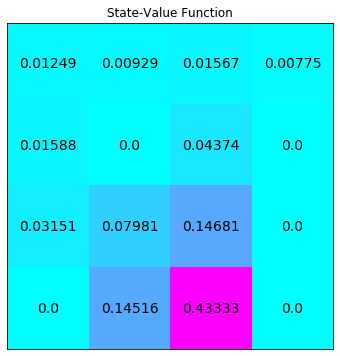

In [16]:
rand_agent = MyRandomAgent(env)
V= policy_MC_evaluation(env, rand_agent)
plot_values_lake(V)

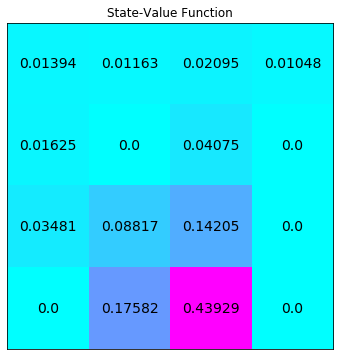

In [17]:
# In reality, here we know the model, we use it to control our results
rand_agent = MyRandomAgent(env)
V = policy_evaluation(env, rand_agent.policy) #see II) dynamic-programming
plot_values_lake(V)

In [18]:
V.sum()

0.9941411498416601

In the same way, we estimate the Q function. 

For Q evaluation
\begin{aligned}
Q(A_t, S_t) &\leftarrow Q(A_t, S_t) + \frac{1}{N_{\text{total}}(A_t, S_t)}(G_t - N_{\text{trajectory}}(A_t, S_t)Q(A_t, S_t))\\
\end{aligned}

And we train an agent, improving its policy by acting greddy.
$\forall s$ $\pi'(.|s) = \arg\max_a Q_\pi(s,a)$.

## Simplest exploration
Without knowing the model, we improve the policy by interacting with the environment. We start with an arbitrary policy, a major problem is caused by a local maximum due to insufficient exploration. To avoid it, we force the agent to act sometimes in a random way (control by an epsilon).

In [19]:
def get_epsilon_greedy_policy(Q_s, epsilon, nA):
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

In [20]:
class MyMCAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1):
        super().__init__(env, gamma, epsilon)
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n])
        self.count_state_actions = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.count_state_actions_by_update = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.episode = []
    def train(self, current_state, action, reward, next_state, done):
        self.episode.append(np.array([current_state, action, reward])) # collect trajectories
        self.count_state_actions[current_state, action] += 1
        self.count_state_actions_by_update[current_state, action] += 1
        if done is True: # we train the agent at every end of episode
            episode = np.asarray(self.episode)
            discount_empirical_return = discount_cumsum(episode[:,2], self.gamma)
            for state in range(len(self.count_state_actions)): # evaluate Q
                for action, count in enumerate(self.count_state_actions[state]):
                    if count > 0 : # evaluate Q
                        self.q[state,action] += (discount_empirical_return[(episode[:,0] == state) & (episode[:,1] == action)].sum() - self.count_state_actions_by_update[state, action] * self.q[state,action]) / count
            self.count_state_actions_by_update = np.zeros((self.env.observation_space.n, self.env.action_space.n))
            self.episode = []
            for state in range(env.observation_space.n): # update policy
                self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

episode: 0 - cum reward 0.0
episode: 1 - cum reward 0.0
episode: 2 - cum reward 0.0
episode: 3 - cum reward 0.0
episode: 4 - cum reward 0.0
episode: 5 - cum reward 0.0
episode: 6 - cum reward 0.0
episode: 7 - cum reward 0.0
episode: 8 - cum reward 0.0
episode: 9 - cum reward 0.0
episode: 10 - cum reward 0.0
episode: 11 - cum reward 0.0
episode: 12 - cum reward 0.0
episode: 13 - cum reward 0.0
episode: 14 - cum reward 0.0
episode: 15 - cum reward 0.0
episode: 16 - cum reward 0.0
episode: 17 - cum reward 0.0
episode: 18 - cum reward 0.0
episode: 19 - cum reward 0.0
episode: 20 - cum reward 0.0
episode: 21 - cum reward 0.0
episode: 22 - cum reward 0.0
episode: 23 - cum reward 0.0
episode: 24 - cum reward 0.0
episode: 25 - cum reward 0.0
episode: 26 - cum reward 0.0
episode: 27 - cum reward 0.0
episode: 28 - cum reward 0.0
episode: 29 - cum reward 0.0
episode: 30 - cum reward 0.0
episode: 31 - cum reward 0.0
episode: 32 - cum reward 0.0
episode: 33 - cum reward 0.0
episode: 34 - cum reward

episode: 391 - cum reward 0.0
episode: 392 - cum reward 0.0
episode: 393 - cum reward 0.0
episode: 394 - cum reward 0.0
episode: 395 - cum reward 0.0
episode: 396 - cum reward 0.0
episode: 397 - cum reward 0.0
episode: 398 - cum reward 0.0
episode: 399 - cum reward 0.0
episode: 400 - cum reward 0.0
episode: 401 - cum reward 0.0
episode: 402 - cum reward 0.0
episode: 403 - cum reward 0.0
episode: 404 - cum reward 0.0
episode: 405 - cum reward 0.0
episode: 406 - cum reward 0.0
episode: 407 - cum reward 0.0
episode: 408 - cum reward 0.0
episode: 409 - cum reward 0.0
episode: 410 - cum reward 0.0
episode: 411 - cum reward 0.0
episode: 412 - cum reward 0.0
episode: 413 - cum reward 0.0
episode: 414 - cum reward 0.0
episode: 415 - cum reward 0.0
episode: 416 - cum reward 0.0
episode: 417 - cum reward 0.0
episode: 418 - cum reward 0.0
episode: 419 - cum reward 0.0
episode: 420 - cum reward 0.0
episode: 421 - cum reward 0.0
episode: 422 - cum reward 0.0
episode: 423 - cum reward 0.0
episode: 4

episode: 759 - cum reward 0.0
episode: 760 - cum reward 0.0
episode: 761 - cum reward 0.0
episode: 762 - cum reward 0.0
episode: 763 - cum reward 0.0
episode: 764 - cum reward 0.0
episode: 765 - cum reward 0.0
episode: 766 - cum reward 0.0
episode: 767 - cum reward 0.0
episode: 768 - cum reward 0.0
episode: 769 - cum reward 0.0
episode: 770 - cum reward 0.0
episode: 771 - cum reward 0.0
episode: 772 - cum reward 0.0
episode: 773 - cum reward 0.0
episode: 774 - cum reward 1.0
episode: 775 - cum reward 0.0
episode: 776 - cum reward 0.0
episode: 777 - cum reward 0.0
episode: 778 - cum reward 0.0
episode: 779 - cum reward 0.0
episode: 780 - cum reward 0.0
episode: 781 - cum reward 0.0
episode: 782 - cum reward 0.0
episode: 783 - cum reward 0.0
episode: 784 - cum reward 0.0
episode: 785 - cum reward 0.0
episode: 786 - cum reward 0.0
episode: 787 - cum reward 0.0
episode: 788 - cum reward 0.0
episode: 789 - cum reward 0.0
episode: 790 - cum reward 0.0
episode: 791 - cum reward 0.0
episode: 7

episode: 1043 - cum reward 0.0
episode: 1044 - cum reward 0.0
episode: 1045 - cum reward 0.0
episode: 1046 - cum reward 0.0
episode: 1047 - cum reward 0.0
episode: 1048 - cum reward 0.0
episode: 1049 - cum reward 0.0
episode: 1050 - cum reward 0.0
episode: 1051 - cum reward 0.0
episode: 1052 - cum reward 0.0
episode: 1053 - cum reward 0.0
episode: 1054 - cum reward 0.0
episode: 1055 - cum reward 0.0
episode: 1056 - cum reward 0.0
episode: 1057 - cum reward 0.0
episode: 1058 - cum reward 0.0
episode: 1059 - cum reward 0.0
episode: 1060 - cum reward 0.0
episode: 1061 - cum reward 1.0
episode: 1062 - cum reward 0.0
episode: 1063 - cum reward 0.0
episode: 1064 - cum reward 0.0
episode: 1065 - cum reward 0.0
episode: 1066 - cum reward 0.0
episode: 1067 - cum reward 0.0
episode: 1068 - cum reward 0.0
episode: 1069 - cum reward 0.0
episode: 1070 - cum reward 0.0
episode: 1071 - cum reward 0.0
episode: 1072 - cum reward 0.0
episode: 1073 - cum reward 0.0
episode: 1074 - cum reward 0.0
episode:

episode: 1329 - cum reward 1.0
episode: 1330 - cum reward 0.0
episode: 1331 - cum reward 0.0
episode: 1332 - cum reward 0.0
episode: 1333 - cum reward 0.0
episode: 1334 - cum reward 0.0
episode: 1335 - cum reward 0.0
episode: 1336 - cum reward 0.0
episode: 1337 - cum reward 0.0
episode: 1338 - cum reward 0.0
episode: 1339 - cum reward 0.0
episode: 1340 - cum reward 0.0
episode: 1341 - cum reward 0.0
episode: 1342 - cum reward 0.0
episode: 1343 - cum reward 0.0
episode: 1344 - cum reward 0.0
episode: 1345 - cum reward 0.0
episode: 1346 - cum reward 0.0
episode: 1347 - cum reward 0.0
episode: 1348 - cum reward 0.0
episode: 1349 - cum reward 0.0
episode: 1350 - cum reward 0.0
episode: 1351 - cum reward 0.0
episode: 1352 - cum reward 0.0
episode: 1353 - cum reward 0.0
episode: 1354 - cum reward 0.0
episode: 1355 - cum reward 0.0
episode: 1356 - cum reward 0.0
episode: 1357 - cum reward 0.0
episode: 1358 - cum reward 0.0
episode: 1359 - cum reward 0.0
episode: 1360 - cum reward 0.0
episode:

episode: 1615 - cum reward 0.0
episode: 1616 - cum reward 0.0
episode: 1617 - cum reward 0.0
episode: 1618 - cum reward 0.0
episode: 1619 - cum reward 0.0
episode: 1620 - cum reward 0.0
episode: 1621 - cum reward 0.0
episode: 1622 - cum reward 0.0
episode: 1623 - cum reward 0.0
episode: 1624 - cum reward 0.0
episode: 1625 - cum reward 0.0
episode: 1626 - cum reward 0.0
episode: 1627 - cum reward 0.0
episode: 1628 - cum reward 0.0
episode: 1629 - cum reward 0.0
episode: 1630 - cum reward 0.0
episode: 1631 - cum reward 0.0
episode: 1632 - cum reward 0.0
episode: 1633 - cum reward 0.0
episode: 1634 - cum reward 0.0
episode: 1635 - cum reward 0.0
episode: 1636 - cum reward 0.0
episode: 1637 - cum reward 0.0
episode: 1638 - cum reward 0.0
episode: 1639 - cum reward 0.0
episode: 1640 - cum reward 0.0
episode: 1641 - cum reward 0.0
episode: 1642 - cum reward 0.0
episode: 1643 - cum reward 0.0
episode: 1644 - cum reward 1.0
episode: 1645 - cum reward 0.0
episode: 1646 - cum reward 0.0
episode:

episode: 1894 - cum reward 0.0
episode: 1895 - cum reward 0.0
episode: 1896 - cum reward 0.0
episode: 1897 - cum reward 0.0
episode: 1898 - cum reward 0.0
episode: 1899 - cum reward 0.0
episode: 1900 - cum reward 0.0
episode: 1901 - cum reward 0.0
episode: 1902 - cum reward 0.0
episode: 1903 - cum reward 0.0
episode: 1904 - cum reward 0.0
episode: 1905 - cum reward 0.0
episode: 1906 - cum reward 0.0
episode: 1907 - cum reward 0.0
episode: 1908 - cum reward 0.0
episode: 1909 - cum reward 0.0
episode: 1910 - cum reward 0.0
episode: 1911 - cum reward 0.0
episode: 1912 - cum reward 0.0
episode: 1913 - cum reward 0.0
episode: 1914 - cum reward 0.0
episode: 1915 - cum reward 0.0
episode: 1916 - cum reward 0.0
episode: 1917 - cum reward 0.0
episode: 1918 - cum reward 0.0
episode: 1919 - cum reward 0.0
episode: 1920 - cum reward 0.0
episode: 1921 - cum reward 0.0
episode: 1922 - cum reward 0.0
episode: 1923 - cum reward 0.0
episode: 1924 - cum reward 0.0
episode: 1925 - cum reward 0.0
episode:

episode: 2196 - cum reward 0.0
episode: 2197 - cum reward 0.0
episode: 2198 - cum reward 0.0
episode: 2199 - cum reward 0.0
episode: 2200 - cum reward 0.0
episode: 2201 - cum reward 0.0
episode: 2202 - cum reward 0.0
episode: 2203 - cum reward 1.0
episode: 2204 - cum reward 0.0
episode: 2205 - cum reward 0.0
episode: 2206 - cum reward 0.0
episode: 2207 - cum reward 0.0
episode: 2208 - cum reward 0.0
episode: 2209 - cum reward 0.0
episode: 2210 - cum reward 0.0
episode: 2211 - cum reward 0.0
episode: 2212 - cum reward 0.0
episode: 2213 - cum reward 0.0
episode: 2214 - cum reward 0.0
episode: 2215 - cum reward 0.0
episode: 2216 - cum reward 0.0
episode: 2217 - cum reward 0.0
episode: 2218 - cum reward 0.0
episode: 2219 - cum reward 0.0
episode: 2220 - cum reward 0.0
episode: 2221 - cum reward 0.0
episode: 2222 - cum reward 0.0
episode: 2223 - cum reward 0.0
episode: 2224 - cum reward 0.0
episode: 2225 - cum reward 0.0
episode: 2226 - cum reward 0.0
episode: 2227 - cum reward 0.0
episode:

episode: 2487 - cum reward 0.0
episode: 2488 - cum reward 0.0
episode: 2489 - cum reward 0.0
episode: 2490 - cum reward 0.0
episode: 2491 - cum reward 0.0
episode: 2492 - cum reward 0.0
episode: 2493 - cum reward 0.0
episode: 2494 - cum reward 0.0
episode: 2495 - cum reward 0.0
episode: 2496 - cum reward 0.0
episode: 2497 - cum reward 0.0
episode: 2498 - cum reward 0.0
episode: 2499 - cum reward 0.0
episode: 2500 - cum reward 0.0
episode: 2501 - cum reward 0.0
episode: 2502 - cum reward 0.0
episode: 2503 - cum reward 0.0
episode: 2504 - cum reward 0.0
episode: 2505 - cum reward 0.0
episode: 2506 - cum reward 0.0
episode: 2507 - cum reward 0.0
episode: 2508 - cum reward 0.0
episode: 2509 - cum reward 0.0
episode: 2510 - cum reward 0.0
episode: 2511 - cum reward 0.0
episode: 2512 - cum reward 0.0
episode: 2513 - cum reward 0.0
episode: 2514 - cum reward 0.0
episode: 2515 - cum reward 1.0
episode: 2516 - cum reward 0.0
episode: 2517 - cum reward 0.0
episode: 2518 - cum reward 0.0
episode:

episode: 2769 - cum reward 0.0
episode: 2770 - cum reward 0.0
episode: 2771 - cum reward 0.0
episode: 2772 - cum reward 0.0
episode: 2773 - cum reward 0.0
episode: 2774 - cum reward 0.0
episode: 2775 - cum reward 0.0
episode: 2776 - cum reward 0.0
episode: 2777 - cum reward 0.0
episode: 2778 - cum reward 0.0
episode: 2779 - cum reward 0.0
episode: 2780 - cum reward 0.0
episode: 2781 - cum reward 1.0
episode: 2782 - cum reward 0.0
episode: 2783 - cum reward 0.0
episode: 2784 - cum reward 0.0
episode: 2785 - cum reward 0.0
episode: 2786 - cum reward 0.0
episode: 2787 - cum reward 0.0
episode: 2788 - cum reward 0.0
episode: 2789 - cum reward 0.0
episode: 2790 - cum reward 0.0
episode: 2791 - cum reward 0.0
episode: 2792 - cum reward 0.0
episode: 2793 - cum reward 0.0
episode: 2794 - cum reward 0.0
episode: 2795 - cum reward 0.0
episode: 2796 - cum reward 0.0
episode: 2797 - cum reward 0.0
episode: 2798 - cum reward 0.0
episode: 2799 - cum reward 0.0
episode: 2800 - cum reward 0.0
episode:

episode: 3075 - cum reward 0.0
episode: 3076 - cum reward 0.0
episode: 3077 - cum reward 0.0
episode: 3078 - cum reward 0.0
episode: 3079 - cum reward 0.0
episode: 3080 - cum reward 0.0
episode: 3081 - cum reward 0.0
episode: 3082 - cum reward 0.0
episode: 3083 - cum reward 0.0
episode: 3084 - cum reward 0.0
episode: 3085 - cum reward 0.0
episode: 3086 - cum reward 0.0
episode: 3087 - cum reward 0.0
episode: 3088 - cum reward 0.0
episode: 3089 - cum reward 0.0
episode: 3090 - cum reward 0.0
episode: 3091 - cum reward 0.0
episode: 3092 - cum reward 0.0
episode: 3093 - cum reward 0.0
episode: 3094 - cum reward 0.0
episode: 3095 - cum reward 0.0
episode: 3096 - cum reward 0.0
episode: 3097 - cum reward 0.0
episode: 3098 - cum reward 0.0
episode: 3099 - cum reward 0.0
episode: 3100 - cum reward 0.0
episode: 3101 - cum reward 0.0
episode: 3102 - cum reward 0.0
episode: 3103 - cum reward 0.0
episode: 3104 - cum reward 0.0
episode: 3105 - cum reward 0.0
episode: 3106 - cum reward 0.0
episode:

episode: 3374 - cum reward 0.0
episode: 3375 - cum reward 0.0
episode: 3376 - cum reward 0.0
episode: 3377 - cum reward 1.0
episode: 3378 - cum reward 0.0
episode: 3379 - cum reward 0.0
episode: 3380 - cum reward 0.0
episode: 3381 - cum reward 0.0
episode: 3382 - cum reward 0.0
episode: 3383 - cum reward 0.0
episode: 3384 - cum reward 0.0
episode: 3385 - cum reward 0.0
episode: 3386 - cum reward 0.0
episode: 3387 - cum reward 0.0
episode: 3388 - cum reward 0.0
episode: 3389 - cum reward 0.0
episode: 3390 - cum reward 0.0
episode: 3391 - cum reward 0.0
episode: 3392 - cum reward 0.0
episode: 3393 - cum reward 0.0
episode: 3394 - cum reward 0.0
episode: 3395 - cum reward 0.0
episode: 3396 - cum reward 0.0
episode: 3397 - cum reward 0.0
episode: 3398 - cum reward 0.0
episode: 3399 - cum reward 0.0
episode: 3400 - cum reward 0.0
episode: 3401 - cum reward 0.0
episode: 3402 - cum reward 0.0
episode: 3403 - cum reward 0.0
episode: 3404 - cum reward 0.0
episode: 3405 - cum reward 0.0
episode:

episode: 3672 - cum reward 0.0
episode: 3673 - cum reward 0.0
episode: 3674 - cum reward 0.0
episode: 3675 - cum reward 1.0
episode: 3676 - cum reward 0.0
episode: 3677 - cum reward 0.0
episode: 3678 - cum reward 0.0
episode: 3679 - cum reward 0.0
episode: 3680 - cum reward 0.0
episode: 3681 - cum reward 0.0
episode: 3682 - cum reward 0.0
episode: 3683 - cum reward 0.0
episode: 3684 - cum reward 0.0
episode: 3685 - cum reward 0.0
episode: 3686 - cum reward 0.0
episode: 3687 - cum reward 0.0
episode: 3688 - cum reward 0.0
episode: 3689 - cum reward 0.0
episode: 3690 - cum reward 0.0
episode: 3691 - cum reward 0.0
episode: 3692 - cum reward 0.0
episode: 3693 - cum reward 0.0
episode: 3694 - cum reward 0.0
episode: 3695 - cum reward 0.0
episode: 3696 - cum reward 0.0
episode: 3697 - cum reward 0.0
episode: 3698 - cum reward 0.0
episode: 3699 - cum reward 0.0
episode: 3700 - cum reward 0.0
episode: 3701 - cum reward 0.0
episode: 3702 - cum reward 0.0
episode: 3703 - cum reward 0.0
episode:

episode: 3960 - cum reward 0.0
episode: 3961 - cum reward 0.0
episode: 3962 - cum reward 0.0
episode: 3963 - cum reward 0.0
episode: 3964 - cum reward 0.0
episode: 3965 - cum reward 0.0
episode: 3966 - cum reward 0.0
episode: 3967 - cum reward 0.0
episode: 3968 - cum reward 0.0
episode: 3969 - cum reward 0.0
episode: 3970 - cum reward 0.0
episode: 3971 - cum reward 0.0
episode: 3972 - cum reward 0.0
episode: 3973 - cum reward 0.0
episode: 3974 - cum reward 0.0
episode: 3975 - cum reward 0.0
episode: 3976 - cum reward 0.0
episode: 3977 - cum reward 0.0
episode: 3978 - cum reward 0.0
episode: 3979 - cum reward 0.0
episode: 3980 - cum reward 1.0
episode: 3981 - cum reward 0.0
episode: 3982 - cum reward 0.0
episode: 3983 - cum reward 0.0
episode: 3984 - cum reward 0.0
episode: 3985 - cum reward 0.0
episode: 3986 - cum reward 0.0
episode: 3987 - cum reward 0.0
episode: 3988 - cum reward 0.0
episode: 3989 - cum reward 0.0
episode: 3990 - cum reward 0.0
episode: 3991 - cum reward 0.0
episode:

episode: 4237 - cum reward 0.0
episode: 4238 - cum reward 0.0
episode: 4239 - cum reward 0.0
episode: 4240 - cum reward 0.0
episode: 4241 - cum reward 0.0
episode: 4242 - cum reward 0.0
episode: 4243 - cum reward 0.0
episode: 4244 - cum reward 0.0
episode: 4245 - cum reward 0.0
episode: 4246 - cum reward 0.0
episode: 4247 - cum reward 0.0
episode: 4248 - cum reward 0.0
episode: 4249 - cum reward 0.0
episode: 4250 - cum reward 0.0
episode: 4251 - cum reward 0.0
episode: 4252 - cum reward 0.0
episode: 4253 - cum reward 0.0
episode: 4254 - cum reward 0.0
episode: 4255 - cum reward 0.0
episode: 4256 - cum reward 0.0
episode: 4257 - cum reward 0.0
episode: 4258 - cum reward 0.0
episode: 4259 - cum reward 0.0
episode: 4260 - cum reward 0.0
episode: 4261 - cum reward 0.0
episode: 4262 - cum reward 0.0
episode: 4263 - cum reward 0.0
episode: 4264 - cum reward 0.0
episode: 4265 - cum reward 0.0
episode: 4266 - cum reward 0.0
episode: 4267 - cum reward 0.0
episode: 4268 - cum reward 0.0
episode:

episode: 4513 - cum reward 0.0
episode: 4514 - cum reward 0.0
episode: 4515 - cum reward 0.0
episode: 4516 - cum reward 0.0
episode: 4517 - cum reward 0.0
episode: 4518 - cum reward 0.0
episode: 4519 - cum reward 0.0
episode: 4520 - cum reward 0.0
episode: 4521 - cum reward 0.0
episode: 4522 - cum reward 1.0
episode: 4523 - cum reward 0.0
episode: 4524 - cum reward 0.0
episode: 4525 - cum reward 0.0
episode: 4526 - cum reward 0.0
episode: 4527 - cum reward 0.0
episode: 4528 - cum reward 0.0
episode: 4529 - cum reward 0.0
episode: 4530 - cum reward 0.0
episode: 4531 - cum reward 0.0
episode: 4532 - cum reward 0.0
episode: 4533 - cum reward 0.0
episode: 4534 - cum reward 0.0
episode: 4535 - cum reward 0.0
episode: 4536 - cum reward 0.0
episode: 4537 - cum reward 0.0
episode: 4538 - cum reward 0.0
episode: 4539 - cum reward 0.0
episode: 4540 - cum reward 0.0
episode: 4541 - cum reward 0.0
episode: 4542 - cum reward 0.0
episode: 4543 - cum reward 0.0
episode: 4544 - cum reward 0.0
episode:

episode: 4809 - cum reward 0.0
episode: 4810 - cum reward 0.0
episode: 4811 - cum reward 0.0
episode: 4812 - cum reward 0.0
episode: 4813 - cum reward 0.0
episode: 4814 - cum reward 0.0
episode: 4815 - cum reward 0.0
episode: 4816 - cum reward 0.0
episode: 4817 - cum reward 0.0
episode: 4818 - cum reward 0.0
episode: 4819 - cum reward 0.0
episode: 4820 - cum reward 0.0
episode: 4821 - cum reward 0.0
episode: 4822 - cum reward 0.0
episode: 4823 - cum reward 0.0
episode: 4824 - cum reward 0.0
episode: 4825 - cum reward 1.0
episode: 4826 - cum reward 0.0
episode: 4827 - cum reward 0.0
episode: 4828 - cum reward 0.0
episode: 4829 - cum reward 0.0
episode: 4830 - cum reward 0.0
episode: 4831 - cum reward 0.0
episode: 4832 - cum reward 0.0
episode: 4833 - cum reward 0.0
episode: 4834 - cum reward 0.0
episode: 4835 - cum reward 0.0
episode: 4836 - cum reward 0.0
episode: 4837 - cum reward 0.0
episode: 4838 - cum reward 0.0
episode: 4839 - cum reward 0.0
episode: 4840 - cum reward 0.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - mc_agent')

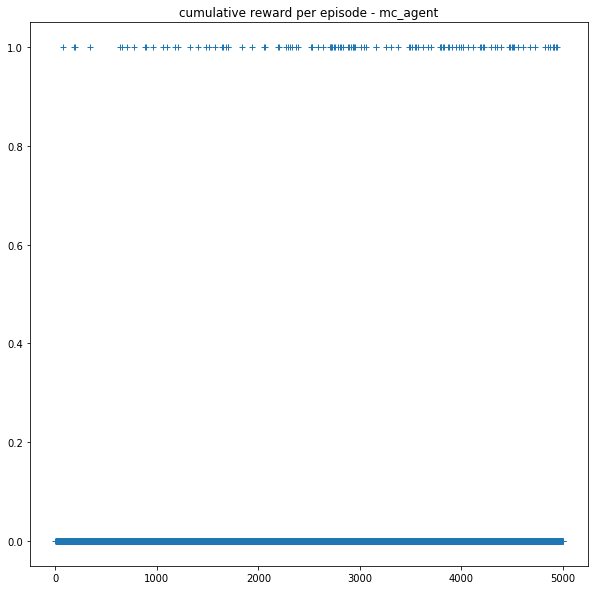

In [21]:
mc_agent = MyMCAgent(env)
rewards = run_experiment_episode_train(env, mc_agent, 5000)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(rewards,'+')
ax.set_title('cumulative reward per episode - mc_agent')

In [22]:
mc_agent.policy

array([[0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025]])

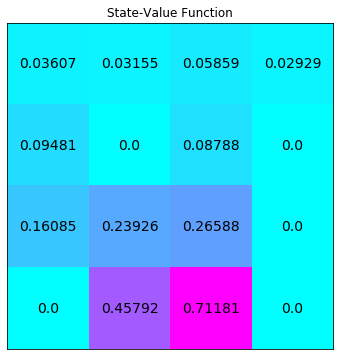

In [23]:
V = policy_evaluation(env, mc_agent.policy)
plot_values_lake(V)

In [24]:
V.sum()

2.1739055258322684

# Temporal-Difference-Learning (Monte-Carlo bootstrap) 

Using monte-carlo, we update $V(S_t)$ in that way

\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \alpha (G_t - V(S_t)) \\
\end{aligned}
We also know (bellman equation) $\mathbb{E}[G_t|S_t=s] = \mathbb{E}[R_{t+1} + \gamma V(S_{t+1})|S_t=s]$. That pushes new estimators/update

TD target $= R_{t+1} + \gamma V(S_{t+1}$)

TD error $=$ target $- V(S_t)$

update:  

\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \alpha (R_{t+1} + \gamma V(S_{t+1}) - V(S_t))
\end{aligned}

In [25]:
#TODO: complete policy td evaluation step
def policy_td_evaluation(env, agent, gamma=1, nb_episode=5000, alpha = .01):
    V = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        count_states = np.zeros(env.observation_space.n)
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            target = reward + gamma * V[state]
            td_error = target - V[current_state]
            count_states[current_state] += 1
            V[current_state] += None #complete here
    return V

In [26]:
#Done: complete policy td evaluation step
def policy_td_evaluation(env, agent, gamma=1, nb_episode=5000, alpha = .01):
    V = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        count_states = np.zeros(env.observation_space.n)
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            target = reward + gamma * V[state]
            td_error = target - V[current_state]
            count_states[current_state] += 1
            V[current_state] += td_error * alpha
    return V

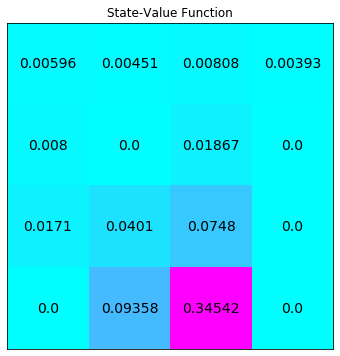

In [27]:
rand_agent = MyRandomAgent(env)
V = policy_td_evaluation(env, rand_agent)
plot_values_lake(V)

### SARSA

Same principle for q function update using Temporal difference$Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma Q(S_{t+1},A_{t+1})−Q(S_t,A_t))$.

In [28]:
class MySarsaAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, gamma, epsilon)
        self.alpha = alpha
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
        self.sarsa = [None, None, None, None, None] #[s,a,r,s,a]
        self.tmp_reward = None
    def qsa_update(self, done):
        if done:
            target = self.sarsa[2]
        else:
            target = self.sarsa[2] + self.gamma * self.q[self.sarsa[-2], self.sarsa[-1]] 
        td_error = target - self.q[self.sarsa[0], self.sarsa[1]]
        self.q[self.sarsa[0], self.sarsa[1]]  += self.alpha * td_error
        
    def train(self, current_state, action, reward, next_state, done):
        self.sarsa[0] = self.sarsa[-2]
        self.sarsa[1] = self.sarsa[-1]
        self.sarsa[2] = self.tmp_reward
        self.sarsa[3] = current_state
        self.sarsa[4] = action
        self.tmp_reward = reward
        if self.sarsa[0] is None:
            pass
        else:
            self.qsa_update(done)
        for state in range(env.observation_space.n):
            self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

episode: 0 - cum reward 0.0
episode: 1 - cum reward 0.0
episode: 2 - cum reward 0.0
episode: 3 - cum reward 0.0
episode: 4 - cum reward 0.0
episode: 5 - cum reward 0.0
episode: 6 - cum reward 0.0
episode: 7 - cum reward 0.0
episode: 8 - cum reward 0.0
episode: 9 - cum reward 0.0
episode: 10 - cum reward 0.0
episode: 11 - cum reward 0.0
episode: 12 - cum reward 0.0
episode: 13 - cum reward 0.0
episode: 14 - cum reward 0.0
episode: 15 - cum reward 0.0
episode: 16 - cum reward 0.0
episode: 17 - cum reward 0.0
episode: 18 - cum reward 0.0
episode: 19 - cum reward 0.0
episode: 20 - cum reward 0.0
episode: 21 - cum reward 0.0
episode: 22 - cum reward 0.0
episode: 23 - cum reward 0.0
episode: 24 - cum reward 0.0
episode: 25 - cum reward 0.0
episode: 26 - cum reward 0.0
episode: 27 - cum reward 0.0
episode: 28 - cum reward 0.0
episode: 29 - cum reward 0.0
episode: 30 - cum reward 0.0
episode: 31 - cum reward 0.0
episode: 32 - cum reward 0.0
episode: 33 - cum reward 0.0
episode: 34 - cum reward

episode: 298 - cum reward 0.0
episode: 299 - cum reward 0.0
episode: 300 - cum reward 0.0
episode: 301 - cum reward 0.0
episode: 302 - cum reward 0.0
episode: 303 - cum reward 0.0
episode: 304 - cum reward 0.0
episode: 305 - cum reward 0.0
episode: 306 - cum reward 0.0
episode: 307 - cum reward 0.0
episode: 308 - cum reward 0.0
episode: 309 - cum reward 0.0
episode: 310 - cum reward 0.0
episode: 311 - cum reward 0.0
episode: 312 - cum reward 0.0
episode: 313 - cum reward 0.0
episode: 314 - cum reward 0.0
episode: 315 - cum reward 0.0
episode: 316 - cum reward 0.0
episode: 317 - cum reward 0.0
episode: 318 - cum reward 0.0
episode: 319 - cum reward 0.0
episode: 320 - cum reward 0.0
episode: 321 - cum reward 0.0
episode: 322 - cum reward 0.0
episode: 323 - cum reward 0.0
episode: 324 - cum reward 0.0
episode: 325 - cum reward 0.0
episode: 326 - cum reward 0.0
episode: 327 - cum reward 0.0
episode: 328 - cum reward 0.0
episode: 329 - cum reward 0.0
episode: 330 - cum reward 0.0
episode: 3

episode: 610 - cum reward 0.0
episode: 611 - cum reward 0.0
episode: 612 - cum reward 0.0
episode: 613 - cum reward 0.0
episode: 614 - cum reward 0.0
episode: 615 - cum reward 0.0
episode: 616 - cum reward 0.0
episode: 617 - cum reward 0.0
episode: 618 - cum reward 0.0
episode: 619 - cum reward 0.0
episode: 620 - cum reward 0.0
episode: 621 - cum reward 0.0
episode: 622 - cum reward 0.0
episode: 623 - cum reward 0.0
episode: 624 - cum reward 0.0
episode: 625 - cum reward 0.0
episode: 626 - cum reward 0.0
episode: 627 - cum reward 0.0
episode: 628 - cum reward 0.0
episode: 629 - cum reward 0.0
episode: 630 - cum reward 0.0
episode: 631 - cum reward 0.0
episode: 632 - cum reward 0.0
episode: 633 - cum reward 0.0
episode: 634 - cum reward 0.0
episode: 635 - cum reward 0.0
episode: 636 - cum reward 0.0
episode: 637 - cum reward 0.0
episode: 638 - cum reward 0.0
episode: 639 - cum reward 0.0
episode: 640 - cum reward 0.0
episode: 641 - cum reward 0.0
episode: 642 - cum reward 0.0
episode: 6

episode: 949 - cum reward 0.0
episode: 950 - cum reward 0.0
episode: 951 - cum reward 0.0
episode: 952 - cum reward 0.0
episode: 953 - cum reward 0.0
episode: 954 - cum reward 0.0
episode: 955 - cum reward 0.0
episode: 956 - cum reward 0.0
episode: 957 - cum reward 0.0
episode: 958 - cum reward 0.0
episode: 959 - cum reward 0.0
episode: 960 - cum reward 0.0
episode: 961 - cum reward 0.0
episode: 962 - cum reward 0.0
episode: 963 - cum reward 0.0
episode: 964 - cum reward 0.0
episode: 965 - cum reward 0.0
episode: 966 - cum reward 1.0
episode: 967 - cum reward 0.0
episode: 968 - cum reward 0.0
episode: 969 - cum reward 0.0
episode: 970 - cum reward 0.0
episode: 971 - cum reward 0.0
episode: 972 - cum reward 1.0
episode: 973 - cum reward 0.0
episode: 974 - cum reward 0.0
episode: 975 - cum reward 0.0
episode: 976 - cum reward 0.0
episode: 977 - cum reward 0.0
episode: 978 - cum reward 1.0
episode: 979 - cum reward 0.0
episode: 980 - cum reward 0.0
episode: 981 - cum reward 0.0
episode: 9

episode: 1263 - cum reward 0.0
episode: 1264 - cum reward 0.0
episode: 1265 - cum reward 0.0
episode: 1266 - cum reward 0.0
episode: 1267 - cum reward 0.0
episode: 1268 - cum reward 0.0
episode: 1269 - cum reward 0.0
episode: 1270 - cum reward 0.0
episode: 1271 - cum reward 0.0
episode: 1272 - cum reward 0.0
episode: 1273 - cum reward 0.0
episode: 1274 - cum reward 0.0
episode: 1275 - cum reward 0.0
episode: 1276 - cum reward 0.0
episode: 1277 - cum reward 0.0
episode: 1278 - cum reward 0.0
episode: 1279 - cum reward 0.0
episode: 1280 - cum reward 0.0
episode: 1281 - cum reward 0.0
episode: 1282 - cum reward 0.0
episode: 1283 - cum reward 0.0
episode: 1284 - cum reward 0.0
episode: 1285 - cum reward 0.0
episode: 1286 - cum reward 0.0
episode: 1287 - cum reward 0.0
episode: 1288 - cum reward 0.0
episode: 1289 - cum reward 0.0
episode: 1290 - cum reward 0.0
episode: 1291 - cum reward 0.0
episode: 1292 - cum reward 0.0
episode: 1293 - cum reward 0.0
episode: 1294 - cum reward 0.0
episode:

episode: 1598 - cum reward 0.0
episode: 1599 - cum reward 0.0
episode: 1600 - cum reward 0.0
episode: 1601 - cum reward 0.0
episode: 1602 - cum reward 0.0
episode: 1603 - cum reward 0.0
episode: 1604 - cum reward 0.0
episode: 1605 - cum reward 0.0
episode: 1606 - cum reward 0.0
episode: 1607 - cum reward 0.0
episode: 1608 - cum reward 0.0
episode: 1609 - cum reward 0.0
episode: 1610 - cum reward 0.0
episode: 1611 - cum reward 0.0
episode: 1612 - cum reward 1.0
episode: 1613 - cum reward 0.0
episode: 1614 - cum reward 0.0
episode: 1615 - cum reward 1.0
episode: 1616 - cum reward 0.0
episode: 1617 - cum reward 0.0
episode: 1618 - cum reward 0.0
episode: 1619 - cum reward 0.0
episode: 1620 - cum reward 0.0
episode: 1621 - cum reward 0.0
episode: 1622 - cum reward 0.0
episode: 1623 - cum reward 0.0
episode: 1624 - cum reward 0.0
episode: 1625 - cum reward 0.0
episode: 1626 - cum reward 0.0
episode: 1627 - cum reward 0.0
episode: 1628 - cum reward 0.0
episode: 1629 - cum reward 0.0
episode:

episode: 1963 - cum reward 0.0
episode: 1964 - cum reward 0.0
episode: 1965 - cum reward 0.0
episode: 1966 - cum reward 0.0
episode: 1967 - cum reward 0.0
episode: 1968 - cum reward 0.0
episode: 1969 - cum reward 0.0
episode: 1970 - cum reward 0.0
episode: 1971 - cum reward 0.0
episode: 1972 - cum reward 0.0
episode: 1973 - cum reward 0.0
episode: 1974 - cum reward 0.0
episode: 1975 - cum reward 0.0
episode: 1976 - cum reward 0.0
episode: 1977 - cum reward 0.0
episode: 1978 - cum reward 0.0
episode: 1979 - cum reward 0.0
episode: 1980 - cum reward 0.0
episode: 1981 - cum reward 0.0
episode: 1982 - cum reward 0.0
episode: 1983 - cum reward 0.0
episode: 1984 - cum reward 0.0
episode: 1985 - cum reward 0.0
episode: 1986 - cum reward 0.0
episode: 1987 - cum reward 0.0
episode: 1988 - cum reward 0.0
episode: 1989 - cum reward 0.0
episode: 1990 - cum reward 0.0
episode: 1991 - cum reward 0.0
episode: 1992 - cum reward 0.0
episode: 1993 - cum reward 0.0
episode: 1994 - cum reward 0.0
episode:

episode: 2282 - cum reward 0.0
episode: 2283 - cum reward 0.0
episode: 2284 - cum reward 0.0
episode: 2285 - cum reward 0.0
episode: 2286 - cum reward 0.0
episode: 2287 - cum reward 0.0
episode: 2288 - cum reward 0.0
episode: 2289 - cum reward 0.0
episode: 2290 - cum reward 0.0
episode: 2291 - cum reward 0.0
episode: 2292 - cum reward 0.0
episode: 2293 - cum reward 0.0
episode: 2294 - cum reward 0.0
episode: 2295 - cum reward 0.0
episode: 2296 - cum reward 0.0
episode: 2297 - cum reward 0.0
episode: 2298 - cum reward 0.0
episode: 2299 - cum reward 0.0
episode: 2300 - cum reward 1.0
episode: 2301 - cum reward 0.0
episode: 2302 - cum reward 0.0
episode: 2303 - cum reward 0.0
episode: 2304 - cum reward 0.0
episode: 2305 - cum reward 0.0
episode: 2306 - cum reward 0.0
episode: 2307 - cum reward 0.0
episode: 2308 - cum reward 0.0
episode: 2309 - cum reward 0.0
episode: 2310 - cum reward 0.0
episode: 2311 - cum reward 0.0
episode: 2312 - cum reward 0.0
episode: 2313 - cum reward 0.0
episode:

episode: 2603 - cum reward 1.0
episode: 2604 - cum reward 0.0
episode: 2605 - cum reward 0.0
episode: 2606 - cum reward 0.0
episode: 2607 - cum reward 0.0
episode: 2608 - cum reward 0.0
episode: 2609 - cum reward 0.0
episode: 2610 - cum reward 0.0
episode: 2611 - cum reward 0.0
episode: 2612 - cum reward 0.0
episode: 2613 - cum reward 0.0
episode: 2614 - cum reward 0.0
episode: 2615 - cum reward 0.0
episode: 2616 - cum reward 0.0
episode: 2617 - cum reward 0.0
episode: 2618 - cum reward 0.0
episode: 2619 - cum reward 0.0
episode: 2620 - cum reward 0.0
episode: 2621 - cum reward 0.0
episode: 2622 - cum reward 1.0
episode: 2623 - cum reward 0.0
episode: 2624 - cum reward 1.0
episode: 2625 - cum reward 0.0
episode: 2626 - cum reward 0.0
episode: 2627 - cum reward 0.0
episode: 2628 - cum reward 0.0
episode: 2629 - cum reward 0.0
episode: 2630 - cum reward 0.0
episode: 2631 - cum reward 0.0
episode: 2632 - cum reward 0.0
episode: 2633 - cum reward 0.0
episode: 2634 - cum reward 0.0
episode:

episode: 2900 - cum reward 0.0
episode: 2901 - cum reward 0.0
episode: 2902 - cum reward 0.0
episode: 2903 - cum reward 0.0
episode: 2904 - cum reward 0.0
episode: 2905 - cum reward 1.0
episode: 2906 - cum reward 0.0
episode: 2907 - cum reward 0.0
episode: 2908 - cum reward 1.0
episode: 2909 - cum reward 0.0
episode: 2910 - cum reward 0.0
episode: 2911 - cum reward 0.0
episode: 2912 - cum reward 0.0
episode: 2913 - cum reward 0.0
episode: 2914 - cum reward 0.0
episode: 2915 - cum reward 0.0
episode: 2916 - cum reward 0.0
episode: 2917 - cum reward 1.0
episode: 2918 - cum reward 0.0
episode: 2919 - cum reward 0.0
episode: 2920 - cum reward 0.0
episode: 2921 - cum reward 0.0
episode: 2922 - cum reward 0.0
episode: 2923 - cum reward 0.0
episode: 2924 - cum reward 0.0
episode: 2925 - cum reward 0.0
episode: 2926 - cum reward 0.0
episode: 2927 - cum reward 0.0
episode: 2928 - cum reward 0.0
episode: 2929 - cum reward 0.0
episode: 2930 - cum reward 0.0
episode: 2931 - cum reward 0.0
episode:

episode: 3176 - cum reward 0.0
episode: 3177 - cum reward 0.0
episode: 3178 - cum reward 0.0
episode: 3179 - cum reward 0.0
episode: 3180 - cum reward 0.0
episode: 3181 - cum reward 0.0
episode: 3182 - cum reward 0.0
episode: 3183 - cum reward 0.0
episode: 3184 - cum reward 1.0
episode: 3185 - cum reward 0.0
episode: 3186 - cum reward 0.0
episode: 3187 - cum reward 1.0
episode: 3188 - cum reward 0.0
episode: 3189 - cum reward 0.0
episode: 3190 - cum reward 0.0
episode: 3191 - cum reward 0.0
episode: 3192 - cum reward 1.0
episode: 3193 - cum reward 0.0
episode: 3194 - cum reward 0.0
episode: 3195 - cum reward 0.0
episode: 3196 - cum reward 0.0
episode: 3197 - cum reward 0.0
episode: 3198 - cum reward 0.0
episode: 3199 - cum reward 1.0
episode: 3200 - cum reward 0.0
episode: 3201 - cum reward 0.0
episode: 3202 - cum reward 0.0
episode: 3203 - cum reward 0.0
episode: 3204 - cum reward 0.0
episode: 3205 - cum reward 0.0
episode: 3206 - cum reward 1.0
episode: 3207 - cum reward 1.0
episode:

episode: 3454 - cum reward 0.0
episode: 3455 - cum reward 0.0
episode: 3456 - cum reward 0.0
episode: 3457 - cum reward 0.0
episode: 3458 - cum reward 0.0
episode: 3459 - cum reward 0.0
episode: 3460 - cum reward 0.0
episode: 3461 - cum reward 0.0
episode: 3462 - cum reward 0.0
episode: 3463 - cum reward 0.0
episode: 3464 - cum reward 0.0
episode: 3465 - cum reward 0.0
episode: 3466 - cum reward 0.0
episode: 3467 - cum reward 0.0
episode: 3468 - cum reward 0.0
episode: 3469 - cum reward 0.0
episode: 3470 - cum reward 0.0
episode: 3471 - cum reward 0.0
episode: 3472 - cum reward 0.0
episode: 3473 - cum reward 0.0
episode: 3474 - cum reward 0.0
episode: 3475 - cum reward 0.0
episode: 3476 - cum reward 0.0
episode: 3477 - cum reward 0.0
episode: 3478 - cum reward 0.0
episode: 3479 - cum reward 0.0
episode: 3480 - cum reward 0.0
episode: 3481 - cum reward 0.0
episode: 3482 - cum reward 0.0
episode: 3483 - cum reward 0.0
episode: 3484 - cum reward 0.0
episode: 3485 - cum reward 0.0
episode:

episode: 3772 - cum reward 0.0
episode: 3773 - cum reward 0.0
episode: 3774 - cum reward 0.0
episode: 3775 - cum reward 0.0
episode: 3776 - cum reward 0.0
episode: 3777 - cum reward 0.0
episode: 3778 - cum reward 0.0
episode: 3779 - cum reward 1.0
episode: 3780 - cum reward 0.0
episode: 3781 - cum reward 0.0
episode: 3782 - cum reward 0.0
episode: 3783 - cum reward 0.0
episode: 3784 - cum reward 0.0
episode: 3785 - cum reward 0.0
episode: 3786 - cum reward 0.0
episode: 3787 - cum reward 0.0
episode: 3788 - cum reward 0.0
episode: 3789 - cum reward 0.0
episode: 3790 - cum reward 0.0
episode: 3791 - cum reward 0.0
episode: 3792 - cum reward 0.0
episode: 3793 - cum reward 0.0
episode: 3794 - cum reward 0.0
episode: 3795 - cum reward 0.0
episode: 3796 - cum reward 0.0
episode: 3797 - cum reward 0.0
episode: 3798 - cum reward 0.0
episode: 3799 - cum reward 0.0
episode: 3800 - cum reward 0.0
episode: 3801 - cum reward 0.0
episode: 3802 - cum reward 0.0
episode: 3803 - cum reward 0.0
episode:

episode: 4040 - cum reward 0.0
episode: 4041 - cum reward 0.0
episode: 4042 - cum reward 0.0
episode: 4043 - cum reward 0.0
episode: 4044 - cum reward 0.0
episode: 4045 - cum reward 0.0
episode: 4046 - cum reward 0.0
episode: 4047 - cum reward 0.0
episode: 4048 - cum reward 0.0
episode: 4049 - cum reward 0.0
episode: 4050 - cum reward 0.0
episode: 4051 - cum reward 0.0
episode: 4052 - cum reward 0.0
episode: 4053 - cum reward 0.0
episode: 4054 - cum reward 1.0
episode: 4055 - cum reward 0.0
episode: 4056 - cum reward 0.0
episode: 4057 - cum reward 0.0
episode: 4058 - cum reward 0.0
episode: 4059 - cum reward 0.0
episode: 4060 - cum reward 0.0
episode: 4061 - cum reward 0.0
episode: 4062 - cum reward 1.0
episode: 4063 - cum reward 0.0
episode: 4064 - cum reward 0.0
episode: 4065 - cum reward 0.0
episode: 4066 - cum reward 0.0
episode: 4067 - cum reward 0.0
episode: 4068 - cum reward 1.0
episode: 4069 - cum reward 0.0
episode: 4070 - cum reward 0.0
episode: 4071 - cum reward 1.0
episode:

episode: 4314 - cum reward 1.0
episode: 4315 - cum reward 0.0
episode: 4316 - cum reward 0.0
episode: 4317 - cum reward 1.0
episode: 4318 - cum reward 0.0
episode: 4319 - cum reward 0.0
episode: 4320 - cum reward 0.0
episode: 4321 - cum reward 1.0
episode: 4322 - cum reward 0.0
episode: 4323 - cum reward 0.0
episode: 4324 - cum reward 0.0
episode: 4325 - cum reward 0.0
episode: 4326 - cum reward 0.0
episode: 4327 - cum reward 0.0
episode: 4328 - cum reward 0.0
episode: 4329 - cum reward 0.0
episode: 4330 - cum reward 1.0
episode: 4331 - cum reward 0.0
episode: 4332 - cum reward 1.0
episode: 4333 - cum reward 0.0
episode: 4334 - cum reward 1.0
episode: 4335 - cum reward 0.0
episode: 4336 - cum reward 1.0
episode: 4337 - cum reward 0.0
episode: 4338 - cum reward 0.0
episode: 4339 - cum reward 0.0
episode: 4340 - cum reward 1.0
episode: 4341 - cum reward 0.0
episode: 4342 - cum reward 1.0
episode: 4343 - cum reward 0.0
episode: 4344 - cum reward 0.0
episode: 4345 - cum reward 0.0
episode:

episode: 4607 - cum reward 1.0
episode: 4608 - cum reward 0.0
episode: 4609 - cum reward 1.0
episode: 4610 - cum reward 0.0
episode: 4611 - cum reward 0.0
episode: 4612 - cum reward 1.0
episode: 4613 - cum reward 0.0
episode: 4614 - cum reward 0.0
episode: 4615 - cum reward 0.0
episode: 4616 - cum reward 0.0
episode: 4617 - cum reward 0.0
episode: 4618 - cum reward 0.0
episode: 4619 - cum reward 0.0
episode: 4620 - cum reward 0.0
episode: 4621 - cum reward 0.0
episode: 4622 - cum reward 0.0
episode: 4623 - cum reward 0.0
episode: 4624 - cum reward 0.0
episode: 4625 - cum reward 0.0
episode: 4626 - cum reward 0.0
episode: 4627 - cum reward 0.0
episode: 4628 - cum reward 0.0
episode: 4629 - cum reward 0.0
episode: 4630 - cum reward 0.0
episode: 4631 - cum reward 0.0
episode: 4632 - cum reward 0.0
episode: 4633 - cum reward 0.0
episode: 4634 - cum reward 0.0
episode: 4635 - cum reward 0.0
episode: 4636 - cum reward 0.0
episode: 4637 - cum reward 0.0
episode: 4638 - cum reward 0.0
episode:

episode: 4920 - cum reward 0.0
episode: 4921 - cum reward 0.0
episode: 4922 - cum reward 1.0
episode: 4923 - cum reward 0.0
episode: 4924 - cum reward 0.0
episode: 4925 - cum reward 0.0
episode: 4926 - cum reward 0.0
episode: 4927 - cum reward 0.0
episode: 4928 - cum reward 0.0
episode: 4929 - cum reward 0.0
episode: 4930 - cum reward 0.0
episode: 4931 - cum reward 0.0
episode: 4932 - cum reward 0.0
episode: 4933 - cum reward 0.0
episode: 4934 - cum reward 0.0
episode: 4935 - cum reward 0.0
episode: 4936 - cum reward 0.0
episode: 4937 - cum reward 0.0
episode: 4938 - cum reward 0.0
episode: 4939 - cum reward 0.0
episode: 4940 - cum reward 0.0
episode: 4941 - cum reward 0.0
episode: 4942 - cum reward 0.0
episode: 4943 - cum reward 0.0
episode: 4944 - cum reward 0.0
episode: 4945 - cum reward 0.0
episode: 4946 - cum reward 0.0
episode: 4947 - cum reward 0.0
episode: 4948 - cum reward 0.0
episode: 4949 - cum reward 0.0
episode: 4950 - cum reward 0.0
episode: 4951 - cum reward 0.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - sarsa_agent')

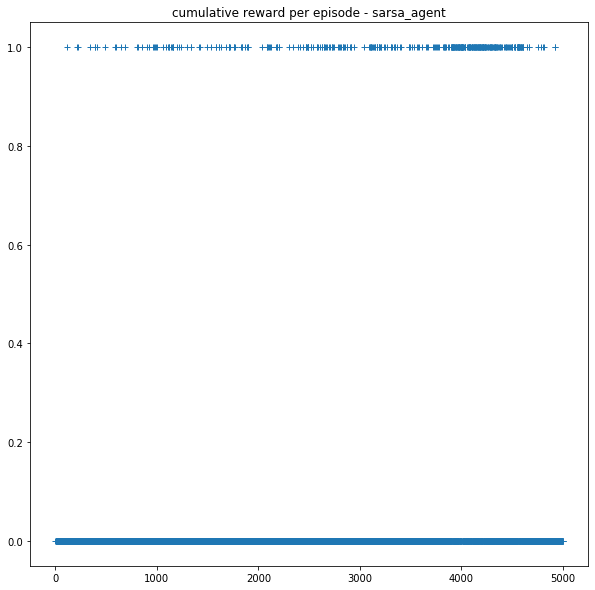

In [29]:
sarsa_agent = MySarsaAgent(env)
rewards = run_experiment_episode_train(env, sarsa_agent, 5000)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(rewards,'+')
ax.set_title('cumulative reward per episode - sarsa_agent')

In [30]:
sarsa_agent.policy

array([[0.025, 0.925, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.925, 0.025],
       [0.925, 0.025, 0.025, 0.025]])

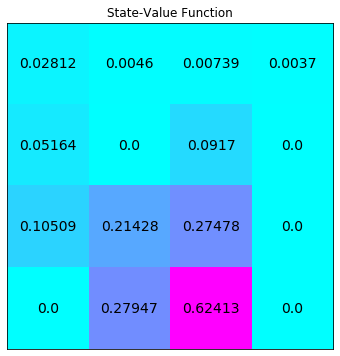

In [31]:
V = policy_evaluation(env, sarsa_agent.policy)
plot_values_lake(V)

In [32]:
V.sum()

1.6849034250601589

### Q-learning

Q learning is an offpolicy sarsa. Instead of update the Q function with the current policy action, it uses a greedy estimation of the policy action

SARAS $Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma Q(S_{t+1},A_{t+1})−Q(S_t,A_t))$

Q-learning $Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma \max_a Q(S_{t+1},a)−Q(S_t,A_t))$

In [33]:
#TODO: write Q learning update
class MyQAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, gamma, epsilon)
        self.alpha = alpha
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
    def qsa_update(self, state, action, reward, next_state, done): 
        pass #complete here
    def train(self, current_state, action, reward, next_state, done):
        self.qsa_update(current_state, action, reward, next_state, done)
        for state in range(env.observation_space.n):
            self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

In [34]:
#Done: write Q learning update
class MyQAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, gamma, epsilon)
        self.alpha = alpha
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
    def qsa_update(self, state, action, reward, next_state, done): 
        if done is False:
            target = reward + self.gamma * np.max(self.q[next_state, :])
        else:
            target = reward
        td_error = target - self.q[state, action]
        self.q[state, action]  += self.alpha * td_error
    def train(self, current_state, action, reward, next_state, done):
        self.qsa_update(current_state, action, reward, next_state, done)
        for state in range(env.observation_space.n):
            self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

episode: 0 - cum reward 0.0
episode: 1 - cum reward 0.0
episode: 2 - cum reward 0.0
episode: 3 - cum reward 0.0
episode: 4 - cum reward 0.0
episode: 5 - cum reward 0.0
episode: 6 - cum reward 0.0
episode: 7 - cum reward 0.0
episode: 8 - cum reward 0.0
episode: 9 - cum reward 0.0
episode: 10 - cum reward 0.0
episode: 11 - cum reward 0.0
episode: 12 - cum reward 0.0
episode: 13 - cum reward 0.0
episode: 14 - cum reward 0.0
episode: 15 - cum reward 0.0
episode: 16 - cum reward 0.0
episode: 17 - cum reward 0.0
episode: 18 - cum reward 0.0
episode: 19 - cum reward 0.0
episode: 20 - cum reward 0.0
episode: 21 - cum reward 0.0
episode: 22 - cum reward 0.0
episode: 23 - cum reward 0.0
episode: 24 - cum reward 0.0
episode: 25 - cum reward 0.0
episode: 26 - cum reward 0.0
episode: 27 - cum reward 0.0
episode: 28 - cum reward 0.0
episode: 29 - cum reward 0.0
episode: 30 - cum reward 0.0
episode: 31 - cum reward 0.0
episode: 32 - cum reward 0.0
episode: 33 - cum reward 0.0
episode: 34 - cum reward

episode: 299 - cum reward 0.0
episode: 300 - cum reward 0.0
episode: 301 - cum reward 1.0
episode: 302 - cum reward 1.0
episode: 303 - cum reward 1.0
episode: 304 - cum reward 1.0
episode: 305 - cum reward 0.0
episode: 306 - cum reward 0.0
episode: 307 - cum reward 0.0
episode: 308 - cum reward 0.0
episode: 309 - cum reward 1.0
episode: 310 - cum reward 1.0
episode: 311 - cum reward 0.0
episode: 312 - cum reward 0.0
episode: 313 - cum reward 1.0
episode: 314 - cum reward 0.0
episode: 315 - cum reward 0.0
episode: 316 - cum reward 0.0
episode: 317 - cum reward 0.0
episode: 318 - cum reward 0.0
episode: 319 - cum reward 0.0
episode: 320 - cum reward 0.0
episode: 321 - cum reward 0.0
episode: 322 - cum reward 1.0
episode: 323 - cum reward 0.0
episode: 324 - cum reward 0.0
episode: 325 - cum reward 1.0
episode: 326 - cum reward 0.0
episode: 327 - cum reward 1.0
episode: 328 - cum reward 0.0
episode: 329 - cum reward 0.0
episode: 330 - cum reward 1.0
episode: 331 - cum reward 1.0
episode: 3

episode: 599 - cum reward 0.0
episode: 600 - cum reward 0.0
episode: 601 - cum reward 0.0
episode: 602 - cum reward 0.0
episode: 603 - cum reward 1.0
episode: 604 - cum reward 0.0
episode: 605 - cum reward 1.0
episode: 606 - cum reward 0.0
episode: 607 - cum reward 1.0
episode: 608 - cum reward 0.0
episode: 609 - cum reward 1.0
episode: 610 - cum reward 0.0
episode: 611 - cum reward 1.0
episode: 612 - cum reward 0.0
episode: 613 - cum reward 1.0
episode: 614 - cum reward 1.0
episode: 615 - cum reward 0.0
episode: 616 - cum reward 0.0
episode: 617 - cum reward 1.0
episode: 618 - cum reward 0.0
episode: 619 - cum reward 0.0
episode: 620 - cum reward 1.0
episode: 621 - cum reward 0.0
episode: 622 - cum reward 1.0
episode: 623 - cum reward 0.0
episode: 624 - cum reward 1.0
episode: 625 - cum reward 0.0
episode: 626 - cum reward 0.0
episode: 627 - cum reward 0.0
episode: 628 - cum reward 0.0
episode: 629 - cum reward 0.0
episode: 630 - cum reward 1.0
episode: 631 - cum reward 0.0
episode: 6

episode: 895 - cum reward 1.0
episode: 896 - cum reward 1.0
episode: 897 - cum reward 0.0
episode: 898 - cum reward 1.0
episode: 899 - cum reward 1.0
episode: 900 - cum reward 0.0
episode: 901 - cum reward 0.0
episode: 902 - cum reward 0.0
episode: 903 - cum reward 0.0
episode: 904 - cum reward 0.0
episode: 905 - cum reward 0.0
episode: 906 - cum reward 0.0
episode: 907 - cum reward 0.0
episode: 908 - cum reward 0.0
episode: 909 - cum reward 0.0
episode: 910 - cum reward 0.0
episode: 911 - cum reward 0.0
episode: 912 - cum reward 0.0
episode: 913 - cum reward 0.0
episode: 914 - cum reward 1.0
episode: 915 - cum reward 1.0
episode: 916 - cum reward 1.0
episode: 917 - cum reward 0.0
episode: 918 - cum reward 0.0
episode: 919 - cum reward 0.0
episode: 920 - cum reward 0.0
episode: 921 - cum reward 0.0
episode: 922 - cum reward 0.0
episode: 923 - cum reward 0.0
episode: 924 - cum reward 0.0
episode: 925 - cum reward 0.0
episode: 926 - cum reward 0.0
episode: 927 - cum reward 1.0
episode: 9

episode: 1186 - cum reward 1.0
episode: 1187 - cum reward 0.0
episode: 1188 - cum reward 0.0
episode: 1189 - cum reward 0.0
episode: 1190 - cum reward 1.0
episode: 1191 - cum reward 0.0
episode: 1192 - cum reward 1.0
episode: 1193 - cum reward 1.0
episode: 1194 - cum reward 0.0
episode: 1195 - cum reward 0.0
episode: 1196 - cum reward 1.0
episode: 1197 - cum reward 0.0
episode: 1198 - cum reward 1.0
episode: 1199 - cum reward 0.0
episode: 1200 - cum reward 0.0
episode: 1201 - cum reward 1.0
episode: 1202 - cum reward 0.0
episode: 1203 - cum reward 0.0
episode: 1204 - cum reward 1.0
episode: 1205 - cum reward 0.0
episode: 1206 - cum reward 1.0
episode: 1207 - cum reward 0.0
episode: 1208 - cum reward 0.0
episode: 1209 - cum reward 0.0
episode: 1210 - cum reward 0.0
episode: 1211 - cum reward 1.0
episode: 1212 - cum reward 0.0
episode: 1213 - cum reward 0.0
episode: 1214 - cum reward 0.0
episode: 1215 - cum reward 1.0
episode: 1216 - cum reward 0.0
episode: 1217 - cum reward 1.0
episode:

episode: 1466 - cum reward 0.0
episode: 1467 - cum reward 1.0
episode: 1468 - cum reward 0.0
episode: 1469 - cum reward 1.0
episode: 1470 - cum reward 0.0
episode: 1471 - cum reward 0.0
episode: 1472 - cum reward 0.0
episode: 1473 - cum reward 0.0
episode: 1474 - cum reward 0.0
episode: 1475 - cum reward 1.0
episode: 1476 - cum reward 1.0
episode: 1477 - cum reward 0.0
episode: 1478 - cum reward 0.0
episode: 1479 - cum reward 0.0
episode: 1480 - cum reward 0.0
episode: 1481 - cum reward 1.0
episode: 1482 - cum reward 0.0
episode: 1483 - cum reward 0.0
episode: 1484 - cum reward 0.0
episode: 1485 - cum reward 1.0
episode: 1486 - cum reward 0.0
episode: 1487 - cum reward 0.0
episode: 1488 - cum reward 0.0
episode: 1489 - cum reward 0.0
episode: 1490 - cum reward 1.0
episode: 1491 - cum reward 0.0
episode: 1492 - cum reward 1.0
episode: 1493 - cum reward 1.0
episode: 1494 - cum reward 0.0
episode: 1495 - cum reward 1.0
episode: 1496 - cum reward 0.0
episode: 1497 - cum reward 1.0
episode:

episode: 1735 - cum reward 0.0
episode: 1736 - cum reward 0.0
episode: 1737 - cum reward 0.0
episode: 1738 - cum reward 0.0
episode: 1739 - cum reward 1.0
episode: 1740 - cum reward 0.0
episode: 1741 - cum reward 0.0
episode: 1742 - cum reward 0.0
episode: 1743 - cum reward 0.0
episode: 1744 - cum reward 1.0
episode: 1745 - cum reward 0.0
episode: 1746 - cum reward 0.0
episode: 1747 - cum reward 0.0
episode: 1748 - cum reward 0.0
episode: 1749 - cum reward 0.0
episode: 1750 - cum reward 0.0
episode: 1751 - cum reward 0.0
episode: 1752 - cum reward 1.0
episode: 1753 - cum reward 0.0
episode: 1754 - cum reward 0.0
episode: 1755 - cum reward 1.0
episode: 1756 - cum reward 0.0
episode: 1757 - cum reward 0.0
episode: 1758 - cum reward 0.0
episode: 1759 - cum reward 1.0
episode: 1760 - cum reward 1.0
episode: 1761 - cum reward 0.0
episode: 1762 - cum reward 1.0
episode: 1763 - cum reward 0.0
episode: 1764 - cum reward 0.0
episode: 1765 - cum reward 0.0
episode: 1766 - cum reward 0.0
episode:

episode: 2009 - cum reward 0.0
episode: 2010 - cum reward 0.0
episode: 2011 - cum reward 0.0
episode: 2012 - cum reward 0.0
episode: 2013 - cum reward 0.0
episode: 2014 - cum reward 0.0
episode: 2015 - cum reward 0.0
episode: 2016 - cum reward 0.0
episode: 2017 - cum reward 0.0
episode: 2018 - cum reward 0.0
episode: 2019 - cum reward 1.0
episode: 2020 - cum reward 0.0
episode: 2021 - cum reward 0.0
episode: 2022 - cum reward 0.0
episode: 2023 - cum reward 0.0
episode: 2024 - cum reward 0.0
episode: 2025 - cum reward 1.0
episode: 2026 - cum reward 0.0
episode: 2027 - cum reward 0.0
episode: 2028 - cum reward 0.0
episode: 2029 - cum reward 1.0
episode: 2030 - cum reward 0.0
episode: 2031 - cum reward 0.0
episode: 2032 - cum reward 0.0
episode: 2033 - cum reward 0.0
episode: 2034 - cum reward 1.0
episode: 2035 - cum reward 1.0
episode: 2036 - cum reward 0.0
episode: 2037 - cum reward 0.0
episode: 2038 - cum reward 0.0
episode: 2039 - cum reward 0.0
episode: 2040 - cum reward 1.0
episode:

episode: 2292 - cum reward 0.0
episode: 2293 - cum reward 0.0
episode: 2294 - cum reward 0.0
episode: 2295 - cum reward 1.0
episode: 2296 - cum reward 0.0
episode: 2297 - cum reward 1.0
episode: 2298 - cum reward 0.0
episode: 2299 - cum reward 0.0
episode: 2300 - cum reward 0.0
episode: 2301 - cum reward 0.0
episode: 2302 - cum reward 0.0
episode: 2303 - cum reward 0.0
episode: 2304 - cum reward 0.0
episode: 2305 - cum reward 0.0
episode: 2306 - cum reward 1.0
episode: 2307 - cum reward 0.0
episode: 2308 - cum reward 0.0
episode: 2309 - cum reward 0.0
episode: 2310 - cum reward 0.0
episode: 2311 - cum reward 0.0
episode: 2312 - cum reward 0.0
episode: 2313 - cum reward 0.0
episode: 2314 - cum reward 1.0
episode: 2315 - cum reward 1.0
episode: 2316 - cum reward 0.0
episode: 2317 - cum reward 1.0
episode: 2318 - cum reward 0.0
episode: 2319 - cum reward 0.0
episode: 2320 - cum reward 0.0
episode: 2321 - cum reward 1.0
episode: 2322 - cum reward 0.0
episode: 2323 - cum reward 0.0
episode:

episode: 2558 - cum reward 0.0
episode: 2559 - cum reward 1.0
episode: 2560 - cum reward 0.0
episode: 2561 - cum reward 1.0
episode: 2562 - cum reward 0.0
episode: 2563 - cum reward 1.0
episode: 2564 - cum reward 1.0
episode: 2565 - cum reward 1.0
episode: 2566 - cum reward 1.0
episode: 2567 - cum reward 0.0
episode: 2568 - cum reward 0.0
episode: 2569 - cum reward 1.0
episode: 2570 - cum reward 0.0
episode: 2571 - cum reward 0.0
episode: 2572 - cum reward 0.0
episode: 2573 - cum reward 1.0
episode: 2574 - cum reward 0.0
episode: 2575 - cum reward 0.0
episode: 2576 - cum reward 0.0
episode: 2577 - cum reward 0.0
episode: 2578 - cum reward 1.0
episode: 2579 - cum reward 1.0
episode: 2580 - cum reward 1.0
episode: 2581 - cum reward 0.0
episode: 2582 - cum reward 1.0
episode: 2583 - cum reward 0.0
episode: 2584 - cum reward 0.0
episode: 2585 - cum reward 0.0
episode: 2586 - cum reward 0.0
episode: 2587 - cum reward 1.0
episode: 2588 - cum reward 0.0
episode: 2589 - cum reward 1.0
episode:

episode: 2824 - cum reward 1.0
episode: 2825 - cum reward 0.0
episode: 2826 - cum reward 0.0
episode: 2827 - cum reward 1.0
episode: 2828 - cum reward 0.0
episode: 2829 - cum reward 1.0
episode: 2830 - cum reward 0.0
episode: 2831 - cum reward 0.0
episode: 2832 - cum reward 1.0
episode: 2833 - cum reward 0.0
episode: 2834 - cum reward 0.0
episode: 2835 - cum reward 0.0
episode: 2836 - cum reward 0.0
episode: 2837 - cum reward 0.0
episode: 2838 - cum reward 0.0
episode: 2839 - cum reward 0.0
episode: 2840 - cum reward 1.0
episode: 2841 - cum reward 0.0
episode: 2842 - cum reward 1.0
episode: 2843 - cum reward 0.0
episode: 2844 - cum reward 0.0
episode: 2845 - cum reward 0.0
episode: 2846 - cum reward 1.0
episode: 2847 - cum reward 1.0
episode: 2848 - cum reward 0.0
episode: 2849 - cum reward 1.0
episode: 2850 - cum reward 0.0
episode: 2851 - cum reward 0.0
episode: 2852 - cum reward 0.0
episode: 2853 - cum reward 1.0
episode: 2854 - cum reward 0.0
episode: 2855 - cum reward 1.0
episode:

episode: 3101 - cum reward 0.0
episode: 3102 - cum reward 0.0
episode: 3103 - cum reward 0.0
episode: 3104 - cum reward 1.0
episode: 3105 - cum reward 0.0
episode: 3106 - cum reward 0.0
episode: 3107 - cum reward 0.0
episode: 3108 - cum reward 0.0
episode: 3109 - cum reward 1.0
episode: 3110 - cum reward 1.0
episode: 3111 - cum reward 1.0
episode: 3112 - cum reward 0.0
episode: 3113 - cum reward 0.0
episode: 3114 - cum reward 0.0
episode: 3115 - cum reward 0.0
episode: 3116 - cum reward 0.0
episode: 3117 - cum reward 0.0
episode: 3118 - cum reward 0.0
episode: 3119 - cum reward 0.0
episode: 3120 - cum reward 0.0
episode: 3121 - cum reward 1.0
episode: 3122 - cum reward 0.0
episode: 3123 - cum reward 0.0
episode: 3124 - cum reward 0.0
episode: 3125 - cum reward 0.0
episode: 3126 - cum reward 1.0
episode: 3127 - cum reward 0.0
episode: 3128 - cum reward 0.0
episode: 3129 - cum reward 1.0
episode: 3130 - cum reward 0.0
episode: 3131 - cum reward 0.0
episode: 3132 - cum reward 0.0
episode:

episode: 3375 - cum reward 0.0
episode: 3376 - cum reward 0.0
episode: 3377 - cum reward 0.0
episode: 3378 - cum reward 1.0
episode: 3379 - cum reward 0.0
episode: 3380 - cum reward 0.0
episode: 3381 - cum reward 0.0
episode: 3382 - cum reward 0.0
episode: 3383 - cum reward 0.0
episode: 3384 - cum reward 1.0
episode: 3385 - cum reward 1.0
episode: 3386 - cum reward 0.0
episode: 3387 - cum reward 1.0
episode: 3388 - cum reward 1.0
episode: 3389 - cum reward 0.0
episode: 3390 - cum reward 0.0
episode: 3391 - cum reward 1.0
episode: 3392 - cum reward 0.0
episode: 3393 - cum reward 0.0
episode: 3394 - cum reward 1.0
episode: 3395 - cum reward 1.0
episode: 3396 - cum reward 0.0
episode: 3397 - cum reward 0.0
episode: 3398 - cum reward 0.0
episode: 3399 - cum reward 1.0
episode: 3400 - cum reward 0.0
episode: 3401 - cum reward 1.0
episode: 3402 - cum reward 0.0
episode: 3403 - cum reward 0.0
episode: 3404 - cum reward 0.0
episode: 3405 - cum reward 0.0
episode: 3406 - cum reward 0.0
episode:

episode: 3649 - cum reward 0.0
episode: 3650 - cum reward 1.0
episode: 3651 - cum reward 1.0
episode: 3652 - cum reward 1.0
episode: 3653 - cum reward 0.0
episode: 3654 - cum reward 0.0
episode: 3655 - cum reward 0.0
episode: 3656 - cum reward 1.0
episode: 3657 - cum reward 1.0
episode: 3658 - cum reward 1.0
episode: 3659 - cum reward 0.0
episode: 3660 - cum reward 1.0
episode: 3661 - cum reward 0.0
episode: 3662 - cum reward 0.0
episode: 3663 - cum reward 0.0
episode: 3664 - cum reward 1.0
episode: 3665 - cum reward 1.0
episode: 3666 - cum reward 0.0
episode: 3667 - cum reward 0.0
episode: 3668 - cum reward 1.0
episode: 3669 - cum reward 1.0
episode: 3670 - cum reward 1.0
episode: 3671 - cum reward 0.0
episode: 3672 - cum reward 1.0
episode: 3673 - cum reward 0.0
episode: 3674 - cum reward 1.0
episode: 3675 - cum reward 0.0
episode: 3676 - cum reward 1.0
episode: 3677 - cum reward 1.0
episode: 3678 - cum reward 1.0
episode: 3679 - cum reward 0.0
episode: 3680 - cum reward 1.0
episode:

episode: 3943 - cum reward 1.0
episode: 3944 - cum reward 1.0
episode: 3945 - cum reward 0.0
episode: 3946 - cum reward 0.0
episode: 3947 - cum reward 0.0
episode: 3948 - cum reward 0.0
episode: 3949 - cum reward 0.0
episode: 3950 - cum reward 0.0
episode: 3951 - cum reward 1.0
episode: 3952 - cum reward 1.0
episode: 3953 - cum reward 0.0
episode: 3954 - cum reward 1.0
episode: 3955 - cum reward 0.0
episode: 3956 - cum reward 0.0
episode: 3957 - cum reward 0.0
episode: 3958 - cum reward 0.0
episode: 3959 - cum reward 0.0
episode: 3960 - cum reward 1.0
episode: 3961 - cum reward 1.0
episode: 3962 - cum reward 0.0
episode: 3963 - cum reward 0.0
episode: 3964 - cum reward 0.0
episode: 3965 - cum reward 0.0
episode: 3966 - cum reward 0.0
episode: 3967 - cum reward 0.0
episode: 3968 - cum reward 1.0
episode: 3969 - cum reward 1.0
episode: 3970 - cum reward 1.0
episode: 3971 - cum reward 0.0
episode: 3972 - cum reward 1.0
episode: 3973 - cum reward 0.0
episode: 3974 - cum reward 0.0
episode:

episode: 4219 - cum reward 1.0
episode: 4220 - cum reward 1.0
episode: 4221 - cum reward 1.0
episode: 4222 - cum reward 1.0
episode: 4223 - cum reward 1.0
episode: 4224 - cum reward 1.0
episode: 4225 - cum reward 0.0
episode: 4226 - cum reward 0.0
episode: 4227 - cum reward 1.0
episode: 4228 - cum reward 1.0
episode: 4229 - cum reward 1.0
episode: 4230 - cum reward 0.0
episode: 4231 - cum reward 0.0
episode: 4232 - cum reward 0.0
episode: 4233 - cum reward 0.0
episode: 4234 - cum reward 0.0
episode: 4235 - cum reward 1.0
episode: 4236 - cum reward 1.0
episode: 4237 - cum reward 0.0
episode: 4238 - cum reward 0.0
episode: 4239 - cum reward 0.0
episode: 4240 - cum reward 0.0
episode: 4241 - cum reward 0.0
episode: 4242 - cum reward 0.0
episode: 4243 - cum reward 0.0
episode: 4244 - cum reward 1.0
episode: 4245 - cum reward 0.0
episode: 4246 - cum reward 0.0
episode: 4247 - cum reward 1.0
episode: 4248 - cum reward 0.0
episode: 4249 - cum reward 0.0
episode: 4250 - cum reward 0.0
episode:

episode: 4490 - cum reward 0.0
episode: 4491 - cum reward 1.0
episode: 4492 - cum reward 1.0
episode: 4493 - cum reward 1.0
episode: 4494 - cum reward 1.0
episode: 4495 - cum reward 0.0
episode: 4496 - cum reward 0.0
episode: 4497 - cum reward 0.0
episode: 4498 - cum reward 0.0
episode: 4499 - cum reward 0.0
episode: 4500 - cum reward 0.0
episode: 4501 - cum reward 1.0
episode: 4502 - cum reward 0.0
episode: 4503 - cum reward 1.0
episode: 4504 - cum reward 1.0
episode: 4505 - cum reward 0.0
episode: 4506 - cum reward 0.0
episode: 4507 - cum reward 1.0
episode: 4508 - cum reward 1.0
episode: 4509 - cum reward 1.0
episode: 4510 - cum reward 1.0
episode: 4511 - cum reward 1.0
episode: 4512 - cum reward 0.0
episode: 4513 - cum reward 1.0
episode: 4514 - cum reward 1.0
episode: 4515 - cum reward 1.0
episode: 4516 - cum reward 0.0
episode: 4517 - cum reward 0.0
episode: 4518 - cum reward 0.0
episode: 4519 - cum reward 0.0
episode: 4520 - cum reward 0.0
episode: 4521 - cum reward 0.0
episode:

episode: 4769 - cum reward 1.0
episode: 4770 - cum reward 0.0
episode: 4771 - cum reward 0.0
episode: 4772 - cum reward 1.0
episode: 4773 - cum reward 1.0
episode: 4774 - cum reward 0.0
episode: 4775 - cum reward 0.0
episode: 4776 - cum reward 1.0
episode: 4777 - cum reward 1.0
episode: 4778 - cum reward 1.0
episode: 4779 - cum reward 0.0
episode: 4780 - cum reward 0.0
episode: 4781 - cum reward 1.0
episode: 4782 - cum reward 0.0
episode: 4783 - cum reward 1.0
episode: 4784 - cum reward 0.0
episode: 4785 - cum reward 1.0
episode: 4786 - cum reward 0.0
episode: 4787 - cum reward 0.0
episode: 4788 - cum reward 0.0
episode: 4789 - cum reward 0.0
episode: 4790 - cum reward 0.0
episode: 4791 - cum reward 0.0
episode: 4792 - cum reward 1.0
episode: 4793 - cum reward 1.0
episode: 4794 - cum reward 1.0
episode: 4795 - cum reward 1.0
episode: 4796 - cum reward 1.0
episode: 4797 - cum reward 0.0
episode: 4798 - cum reward 0.0
episode: 4799 - cum reward 0.0
episode: 4800 - cum reward 1.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - q_agent')

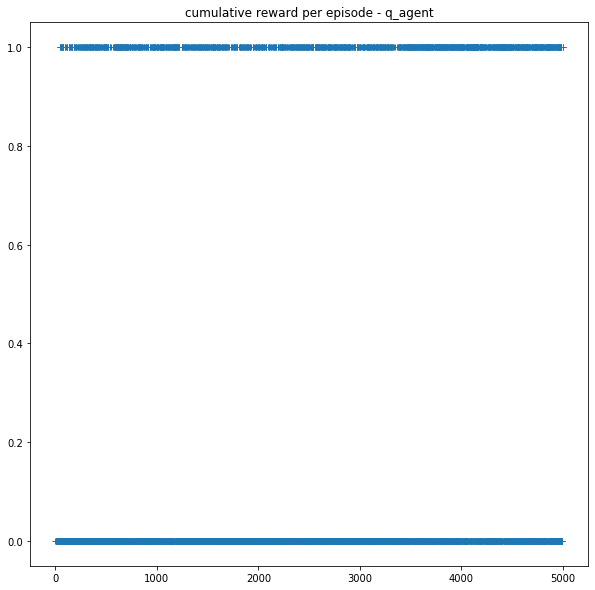

In [35]:
q_agent = MyQAgent(env)
rewards = run_experiment_episode_train(env, q_agent, 5000)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(rewards,'+')
ax.set_title('cumulative reward per episode - q_agent')

In [36]:
q_agent.policy

array([[0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025]])

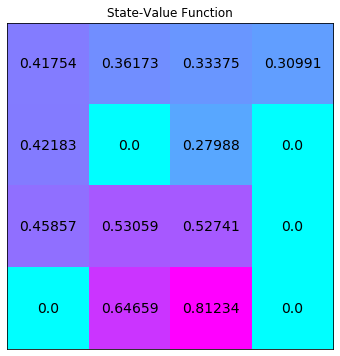

In [37]:
V = policy_evaluation(env, q_agent.policy)
plot_values_lake(V)

In [38]:
V.sum()

5.100116629064201

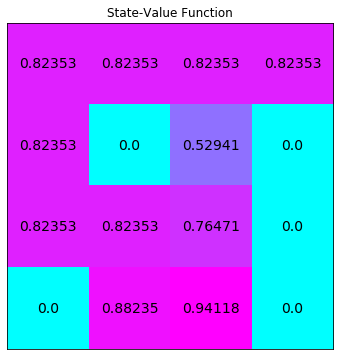

8.882351322605881

In [39]:
policy_best, V_best = value_iteration(env)
plot_values_lake(V_best)
V_best.sum()

In [40]:
#Question: Why we don't have the optimal policy?

In [41]:
q_policy_no_eps = np.zeros(q_agent.policy.shape)
q_policy_no_eps[np.arange(len(q_policy_no_eps)), q_agent.policy.argmax(axis=1)] = 1

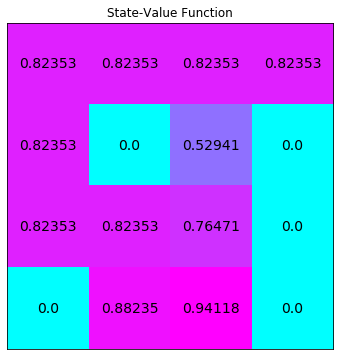

8.882351322605881

In [42]:
V = policy_evaluation(env, q_policy_no_eps)
plot_values_lake(V)
V_best.sum()

### keep in mind:
\begin{aligned}
MDP \rightarrow V(S_t) &\leftarrow \mathbb{E}[R_{t+1} + \gamma V(S_{t+1})] \\
MC \rightarrow V(S_t) &\leftarrow V(S_t) + \alpha (G_t - V(S_{t+1})\\
TD \rightarrow V(S_t) &\leftarrow V(S_t) + \alpha (R_{t+1} + \gamma V(S_{t+1}) - V(S_t))
\end{aligned}